# Emotion Detection Project



## Standard Imports

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Data

* The data used for training was taken from kaggle. Data can be downloaded via this link https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset

* The data consits of `grayscale` images sorted under `7 different` categories or emotions


In [ ]:
data_dir = "/content/drive/My Drive/facial_images"

In [ ]:
os.listdir(data_dir)

['train', 'validation']

In [ ]:
train_path = data_dir + '/train/'
test_path = data_dir + '/validation/'

In [ ]:
train_path

'/content/drive/My Drive/facial_images/train/'

In [ ]:
os.listdir(train_path)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
os.listdir(train_path + 'angry')[0]

'5633.jpg'

In [ ]:
facial_expression_eg = train_path + 'angry/' + '5633.jpg' 
imread(facial_expression_eg).shape

(48, 48)

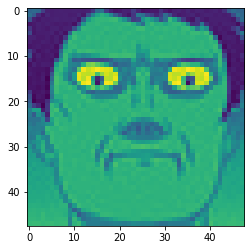

In [ ]:
plt.imshow(imread(facial_expression_eg))

## Resizing all the images to the same size

In [ ]:
dim1 = []
dim2 = []

for image_filename in os.listdir(train_path + 'angry'):
  img = imread(train_path + 'angry/' + image_filename)
  d1, d2 = img.shape
  dim1.append(d1)
  dim2.append(d2)

In [ ]:
np.mean(dim1)

48.0

In [ ]:
np.mean(dim2)

48.0

In [ ]:
image_shape = (48, 48, 1)

## 2. Improvement

* Creating Image genrators
* Improving the image data by rotating, shifting, zooming etc

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
img = imread(train_path + 'angry/' + os.listdir(train_path + 'angry')[0])
img

array([[201, 204, 214, ..., 210, 216, 213],
       [206, 211, 217, ..., 204, 212, 221],
       [212, 218, 218, ..., 205, 214, 215],
       ...,
       [  1,  10,  10, ...,  11,  12,  21],
       [  7,   6,  10, ...,  10,   9,  19],
       [ 10,   3,   4, ...,   8,  16,  21]], dtype=uint8)

In [ ]:
img.max()

224

In [ ]:
image_gen = ImageDataGenerator(width_shift_range=0.1,
                               height_shift_range = 0.1,
                               zoom_range = 0.1,
                               rescale = 1. / 255)

In [ ]:
image_gen.flow_from_directory(train_path)

Found 28641 images belonging to 7 classes.


In [ ]:
image_gen.flow_from_directory(test_path)

Found 7066 images belonging to 7 classes.


## 3. Model

Creating our model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout

In [ ]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size= (3, 3),
                 activation='relu', 
                 input_shape = image_shape))

model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Conv2D(filters=128, kernel_size= (3, 3),
                 activation='relu'))

model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Conv2D(filters=512, kernel_size= (3, 3),
                 activation='relu'))

model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 8, 8, 512)         590336    
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)            

In [ ]:
batch_size = 128

In [ ]:
datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

In [ ]:
train_image_gen = datagen_train.flow_from_directory(train_path, 
                              target_size=(48, 48), 
                              color_mode ="grayscale",
                              class_mode="categorical",
                              batch_size=batch_size,
                              shuffle = True)

Found 28641 images belonging to 7 classes.


In [ ]:
test_image_gen = datagen_validation.flow_from_directory(test_path, 
                              target_size=(48, 48), 
                              color_mode ="grayscale",
                              class_mode="categorical",
                              batch_size=batch_size,
                              shuffle = False)

Found 7066 images belonging to 7 classes.


## 4. Training

* Creating checkpoints
* Training the model

In [ ]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='val_loss', patience=2)

callbacks_list = [checkpoint, early_stop]


results = model.fit_generator(generator = train_image_gen,
                              epochs = 50, 
                              validation_data = test_image_gen,
                              callbacks = callbacks_list,
                              verbose = 1)

Epoch 1/50
224/224 [==============================] - 17309s 77s/step - loss: 2.6328 - accuracy: 0.3152 - val_loss: 1.4944 - val_accuracy: 0.4321
Epoch 2/50
224/224 [==============================] - 76s 338ms/step - loss: 1.4617 - accuracy: 0.4358 - val_loss: 1.3983 - val_accuracy: 0.4742
Epoch 3/50
224/224 [==============================] - 77s 342ms/step - loss: 1.3390 - accuracy: 0.4890 - val_loss: 1.2963 - val_accuracy: 0.5099
Epoch 4/50
224/224 [==============================] - 76s 338ms/step - loss: 1.2538 - accuracy: 0.5269 - val_loss: 1.2571 - val_accuracy: 0.5284
Epoch 5/50
224/224 [==============================] - 78s 348ms/step - loss: 1.1723 - accuracy: 0.5551 - val_loss: 1.2193 - val_accuracy: 0.5488
Epoch 6/50
224/224 [==============================] - 74s 330ms/step - loss: 1.0884 - accuracy: 0.5899 - val_loss: 1.2177 - val_accuracy: 0.5601
Epoch 7/50
224/224 [==============================] - 74s 331ms/step - loss: 1.0150 - accuracy: 0.6191 - val_loss: 1.2395 - val_a

## 5. Evaluating the model and getting predictions

In [ ]:
train_image_gen.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
model.evaluate(test_image_gen)

56/56 [==============================] - 12s 219ms/step - loss: 1.2373 - accuracy: 0.5620


[1.237287998199463, 0.5619869828224182]

In [ ]:
pred = model.predict_generator(test_image_gen, verbose=1)

56/56 [==============================] - 12s 222ms/step


In [ ]:
model.save('/content/drive/My Drive/facial_images/finalized_model.h5')

In [ ]:
pred

array([[3.3906513e-01, 4.7993535e-04, 2.1793222e-02, ..., 5.2521342e-01,
        5.7163499e-02, 3.3476189e-04],
       [3.7947854e-01, 2.2816332e-03, 4.0332451e-01, ..., 3.4772363e-02,
        9.5218211e-02, 2.8441243e-02],
       [4.8184630e-01, 4.7848742e-03, 9.2112653e-02, ..., 8.3493575e-02,
        2.6627725e-01, 9.0321834e-04],
       ...,
       [1.3616121e-01, 1.4496357e-03, 8.8644505e-02, ..., 2.6528615e-01,
        4.3928035e-02, 4.6246490e-01],
       [3.1695258e-02, 1.0715829e-04, 1.5199918e-01, ..., 5.3630507e-01,
        4.6110481e-02, 4.7617055e-02],
       [7.6421853e-03, 5.8407254e-06, 6.3585430e-02, ..., 4.1685737e-04,
        1.9303168e-04, 6.8838602e-01]], dtype=float32)

In [ ]:
y_pred = [np.argmax(probas) for probas in pred]

In [ ]:
y_pred[2]

0

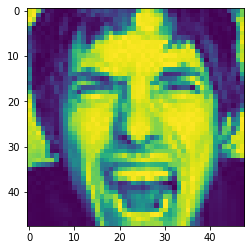

In [ ]:
plt.imshow(imread(test_path + 'angry/' + os.listdir(test_path + 'angry')[1]))

In [ ]:
sample_path = test_path + 'angry/' + os.listdir(test_path + 'angry')[1]

In [ ]:
sample_path

'/content/drive/My Drive/facial_images/validation/angry/28867.jpg'

In [ ]:
img = imread(sample_path).reshape((1, 48,48, 1))

In [ ]:
sample_pred = model.predict(img)

In [ ]:
result = np.argmax(sample_pred)

In [ ]:
for key in train_image_gen.class_indices.keys():
 
 if(train_image_gen.class_indices[key] == result):
  ans = key
  break

In [ ]:
print(ans)

angry


## Evaluating on custom images




In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [2]:
model = load_model('/content/drive/My Drive/facial_images/finalized_model.h5')

In [3]:
sample_path = '/content/drive/My Drive/facial_images/my_image.jpg'

my_image = image.load_img(sample_path,
               target_size = (48, 48),
               grayscale = True)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [4]:
my_image_array = image.img_to_array(my_image)

In [5]:
type(my_image_array)

numpy.ndarray

In [8]:
import numpy as np
my_image_array = np.expand_dims(my_image_array, axis = 0)

In [9]:
my_image_array.shape

(1, 48, 48, 1)

In [11]:
result = np.argmax(model.predict(my_image_array))
result

4

In [12]:
identification = {0 : 'angry',
 1 : 'disgust',
 2 : 'fear',
 3 : 'happy',
 4 : 'neutral',
 5 : 'sad',
 6 : 'surprise'}

In [13]:
identification[result]

'neutral'